In [1]:
import mne
import sys
import numpy as np
from matplotlib import pyplot as plt
from asrpy import ASR
from mne.preprocessing import ICA, create_eog_epochs
from mne_bids import (BIDSPath,read_raw_bids)


In [2]:
# path to datasets.
bids_root = "ds003846"

Compute_evokeds_for_session encapsulates the entire pipeline for one subject and one session.
- Load data
- Preprocess data
- ERP analysis

For more details, see the pipeline_one-sub_one-session.ipynb notebook.

In [3]:
def compute_evokeds_for_session(subject: str, session: str):

    # Load data
    bids_path = BIDSPath(subject=subject, task="PredictionError", session=session,
                     datatype='eeg', suffix='eeg',
                     root=bids_root)
    raw = read_raw_bids(bids_path)

    # Preprocessing
    # 50Hz noise: Remove 50 Hz line noise and also 150 Hz noise
    raw_filtered = raw.load_data().copy().notch_filter(freqs=[50, 150])
    # Filter(Preprocessing): Apply a bandpass filter
    raw_filtered = raw_filtered.filter(0.1, 125)
    # Resampling: to 250Hz
    raw_filtered_resampled = raw_filtered.resample(250)
    # Add montage and set reference channel
    raw_filtered_resampled = mne.add_reference_channels(
        raw_filtered_resampled, ref_channels=['FCz'], copy=False
    )
    montage = mne.channels.make_standard_montage('standard_1020')
    raw_filtered_resampled.set_montage(montage)
    # Re-referencing: to average
    raw_filtered_resampled_referenced = raw_filtered_resampled.set_eeg_reference('average')
    
    # Artefact Cleaning: ASR
    # asr = ASR(sfreq=raw_filtered_resampled_referenced.info['sfreq'], cutoff=5.)
    # asr.fit(raw_filtered_resampled_referenced)
    # raw_filtered_resampled_referenced_asr = asr.transform(raw_filtered_resampled_referenced)
    
    # ASR is too time-consuming for long data, skip for now
    raw_filtered_resampled_referenced_asr = raw_filtered_resampled_referenced

    # Eye Blinks: ICA
    ica = ICA(n_components=20, method='fastica', random_state=97)
    ica.fit(raw_filtered_resampled_referenced_asr)
    eog_indices, eog_scores = ica.find_bads_eog(raw_filtered_resampled_referenced_asr)
    ica.exclude = eog_indices
    raw_filtered_resampled_referenced_asr_ica = ica.apply(raw_filtered_resampled_referenced_asr.copy())

    # ERP Analysis
    raw_preprocessed = raw_filtered_resampled_referenced_asr_ica
    evts, evts_dict = mne.events_from_annotations(raw_preprocessed)
    event_id_normal = {k: v for k, v in evts_dict.items()
                        if "normal_or_conflict:normal" in k and "box:touched" in k}
    evts_normal = evts[np.isin(evts[:, 2], list(event_id_normal.values()))]
    event_id_conflict = {k: v for k, v in evts_dict.items()
                        if "normal_or_conflict:conflict" in k and "box:touched" in k}
    evts_conflict = evts[np.isin(evts[:, 2], list(event_id_conflict.values()))]

    # Epoching 
    tmin, tmax = -0.1, 1.0  # -100ms to +1s
    epochs_normal = mne.Epochs(
        raw_preprocessed,
        evts_normal,
        event_id_normal,
        tmin=tmin,
        tmax=tmax,
        baseline=None, 
        preload=True,
        event_repeated='drop'  
    )
    epochs_conflict = mne.Epochs(
        raw_preprocessed,
        evts_conflict,
        event_id_conflict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        preload=True,
        event_repeated='drop'  
    )
    # EEG Delay Correction 
    epochs_normal = epochs_normal.shift_time(-0.063)
    epochs_conflict = epochs_conflict.shift_time(-0.063)
    # Baseline Correction: Apply bandpass filter 0.5-35Hz instead of explicit baseline correction
    epochs_normal = epochs_normal.filter(0.5, 35)
    epochs_conflict = epochs_conflict.filter(0.5, 35)
    # Electrode: FCz Comparison 
    evoked_normal = epochs_normal.copy().pick("FCz").average()
    evoked_conflict = epochs_conflict.copy().pick("FCz").average()

    # Plotting Evoked Responses
    evoked_normal.comment = f"{session}_match"
    evoked_conflict.comment = f"{session}_mismatch"

    return evoked_normal, evoked_conflict


In [4]:
# Main processing for subject 02 across all sessions
subject = "02"
sessions = ["EMS", "Vibro", "Visual"]

evokeds_match = {}     # A ：match
evokeds_mismatch = {}  # B ：mismatch

for ses in sessions:
    ev_norm, ev_conf = compute_evokeds_for_session(subject, ses)
    evokeds_match[ses] = ev_norm
    evokeds_mismatch[ses] = ev_conf
    print(f"Completed processing for subject {subject}, session {ses}")


Extracting parameters from ds003846/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from ds003846/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_events.tsv.
Reading channel info from ds003846/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_channels.tsv.
Reading 0 ... 258029  =      0.000 ...   516.064 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/2909016124.py:7: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 58
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 31.25 Hz (-6 dB cutoff frequency: 140.62 Hz)
- Filter length: 16501 samples (33.002 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 64 channels (please be patient, this may take a while)


/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/2909016124.py:21: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered_resampled.set_montage(montage)


Selecting by number: 20 components
Fitting ICA took 2.0s.
Using EOG channel: Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition

/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/utils/linalg.py:243: RuntimeWarning: divide by zero encountered in matmul
  return (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/utils/linalg.py:243: RuntimeWarning: overflow encountered in matmul
  return (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/utils/linalg.py:243: RuntimeWarning: invalid

0 bad epochs dropped
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 50 events and 276 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 0.5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1651 samples (6.604 s)



/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/2909016124.py:76: RuntimeWarning: filter_length (1651) is longer than the signal (276), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_normal = epochs_normal.filter(0.5, 35)


Setting up band-pass filter from 0.5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1651 samples (6.604 s)

Completed processing for subject 02, session EMS
Extracting parameters from ds003846/sub-02/ses-Vibro/eeg/sub-02_ses-Vibro_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from ds003846/sub-02/ses-Vibro/eeg/sub-02_ses-Vibro_task-PredictionError_events.tsv.


/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/2909016124.py:77: RuntimeWarning: filter_length (1651) is longer than the signal (276), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_conflict = epochs_conflict.filter(0.5, 35)


Reading channel info from ds003846/sub-02/ses-Vibro/eeg/sub-02_ses-Vibro_task-PredictionError_channels.tsv.
Reading 0 ... 838759  =      0.000 ...  1677.540 secs...


/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/2909016124.py:7: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 58
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 31.25 Hz (-6 dB cutoff frequency: 140.62 Hz)
- Filter length: 16501 samples (33.002 s)

EEG channe

/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/2909016124.py:21: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered_resampled.set_montage(montage)


Selecting by number: 20 components
Fitting ICA took 3.1s.
Using EOG channel: Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)



/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/utils/linalg.py:243: RuntimeWarning: divide by zero encountered in matmul
  return (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/utils/linalg.py:243: RuntimeWarning: overflow encountered in matmul
  return (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/utils/linalg.py:243: RuntimeWarning: invalid

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:2;condition:vibro;training:false'), np.str_('block:start;currentBlockNr:3;condition:vibro;training:false'), np.str_('box:spawned;condition:vibro;trial_nr:100;normal_or_conflict:conflict;cube:CubeLeft (Uni

/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/preprocessing/ica.py:2405: RuntimeWarning: divide by zero encountered in matmul
  mixing = pca_components.T @ mixing
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/preprocessing/ica.py:2405: RuntimeWarning: overflow encountered in matmul
  mixing = pca_components.T @ mixing
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/preprocessing/ica.py:2405: RuntimeWarning: invalid value encountered in matmul
  mixing = pca_components.T @ mixing
/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/2909016124.py:76: RuntimeWarning: filter_length (1651) is longer than the signal (276), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_normal = epochs_normal.filter(0.5, 35)


Setting up band-pass filter from 0.5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1651 samples (6.604 s)



/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/2909016124.py:77: RuntimeWarning: filter_length (1651) is longer than the signal (276), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_conflict = epochs_conflict.filter(0.5, 35)


Completed processing for subject 02, session Vibro
Extracting parameters from ds003846/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading events from ds003846/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_events.tsv.
Reading channel info from ds003846/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_channels.tsv.
Reading 0 ... 959079  =      0.000 ...  1918.184 secs...


/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/2909016124.py:7: RuntimeWarning: Unable to map the following column(s) to to MNE:
cap_size: 58
block_1: Visual
block_2: Visual + Vibro
block_3: Visual + Vibro + EMS
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 31.25 Hz (-6 dB cutoff frequency: 140.62 Hz)
- Filter length: 16501 samples (33.002 s)

EEG channe

/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/2909016124.py:21: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_filtered_resampled.set_montage(montage)


Selecting by number: 20 components
Fitting ICA took 3.4s.
Using EOG channel: Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)



/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/utils/linalg.py:243: RuntimeWarning: divide by zero encountered in matmul
  return (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/utils/linalg.py:243: RuntimeWarning: overflow encountered in matmul
  return (u @ vh[:rank]).conj().T
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/utils/linalg.py:243: RuntimeWarning: invalid

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Used Annotations descriptions: [np.str_('block:end;currentBlockNr:3;condition:visual;training:false'), np.str_('block:start;currentBlockNr:1;condition:visual;training:false'), np.str_('block:start;currentBlockNr:2;condition:visual;training:false'), np.str_('block:start;currentBlockNr:3;condition:visual;training:false'), np.str_('box:spawned;

/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/preprocessing/ica.py:2405: RuntimeWarning: divide by zero encountered in matmul
  mixing = pca_components.T @ mixing
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/preprocessing/ica.py:2405: RuntimeWarning: overflow encountered in matmul
  mixing = pca_components.T @ mixing
/Users/gujianyang/miniforge3/envs/eeg/lib/python3.10/site-packages/mne/preprocessing/ica.py:2405: RuntimeWarning: invalid value encountered in matmul
  mixing = pca_components.T @ mixing
/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/2909016124.py:76: RuntimeWarning: filter_length (1651) is longer than the signal (276), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_normal = epochs_normal.filter(0.5, 35)


Setting up band-pass filter from 0.5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1651 samples (6.604 s)



/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/2909016124.py:77: RuntimeWarning: filter_length (1651) is longer than the signal (276), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_conflict = epochs_conflict.filter(0.5, 35)


Completed processing for subject 02, session Visual


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/1628254252.py:8: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


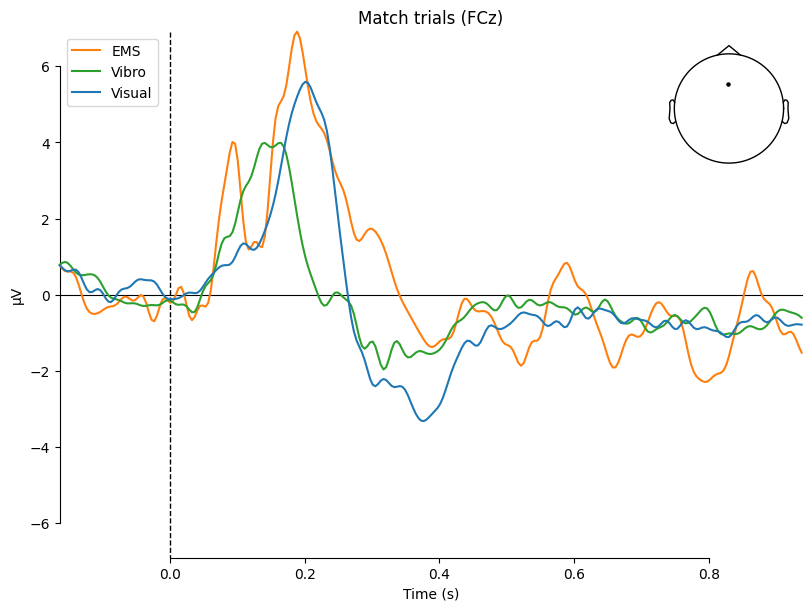

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/4r/xm8pwn3914d4rn35mt4w0q9m0000gn/T/ipykernel_62156/1628254252.py:17: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


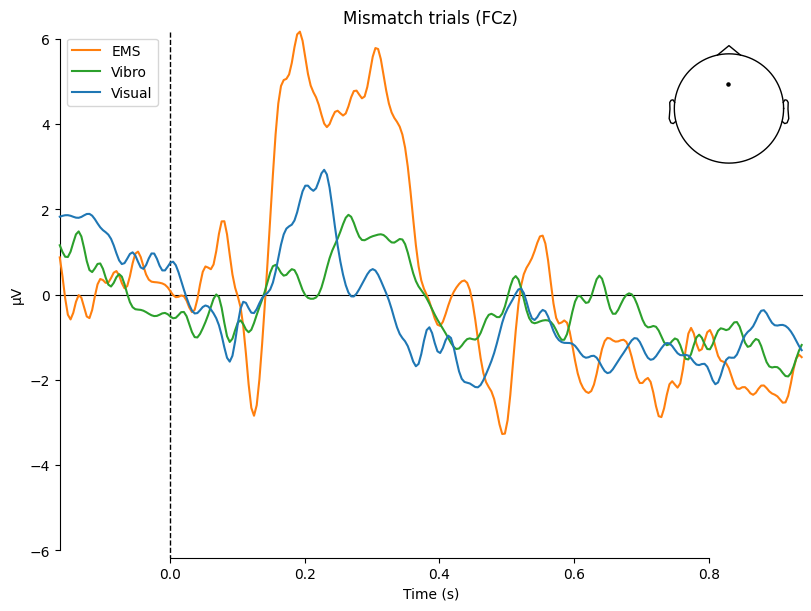

[<Figure size 800x600 with 2 Axes>]

In [5]:
# Plotting 

colors = {"Visual": 'C0',   
          "EMS": 'C1',      
          "Vibro": 'C2'}    

# A. match trials
mne.viz.plot_compare_evokeds(
    evokeds_match,
    picks="FCz",
    colors=colors,
    combine="mean",
    title="Match trials (FCz)"
)

# B. mismatch trials
mne.viz.plot_compare_evokeds(
    evokeds_mismatch,
    picks="FCz",
    colors=colors,
    combine="mean",
    title="Mismatch trials (FCz)"
)
